Remove 22 attributes with ≥50% NaN values:

W: 97.7% NaN
  -> Asbestos-free: 3
  -> Asbestos: 0

Ga: 70.3% NaN
  -> Asbestos-free: 34
  -> Asbestos: 4

Pt: 100.0% NaN
  -> No non-NaN datapoints for this attribute.

La: 87.5% NaN
  -> Asbestos-free: 11
  -> Asbestos: 5

Hf: 92.2% NaN
  -> Asbestos-free: 10
  -> Asbestos: 0

Cd: 96.9% NaN
  -> Asbestos-free: 3
  -> Asbestos: 1

Th: 82.8% NaN
  -> Asbestos-free: 20
  -> Asbestos: 2

Bi: 94.5% NaN
  -> Asbestos-free: 7
  -> Asbestos: 0

Cl: 82.8% NaN
  -> Asbestos-free: 10
  -> Asbestos: 12

Sn: 96.9% NaN
  -> Asbestos-free: 4
  -> Asbestos: 0

Ag: 100.0% NaN
  -> No non-NaN datapoints for this attribute.

Ta: 100.0% NaN
  -> No non-NaN datapoints for this attribute.

Tl: 100.0% NaN
  -> No non-NaN datapoints for this attribute.

U: 85.9% NaN
  -> Asbestos-free: 17
  -> Asbestos: 1

Au: 100.0% NaN
  -> No non-NaN datapoints for this attribute.

V: 90.6% NaN
  -> Asbestos-free: 12
  -> Asbestos: 0

Hg: 98.4% NaN
  -> Asbestos-free: 2
  -> A

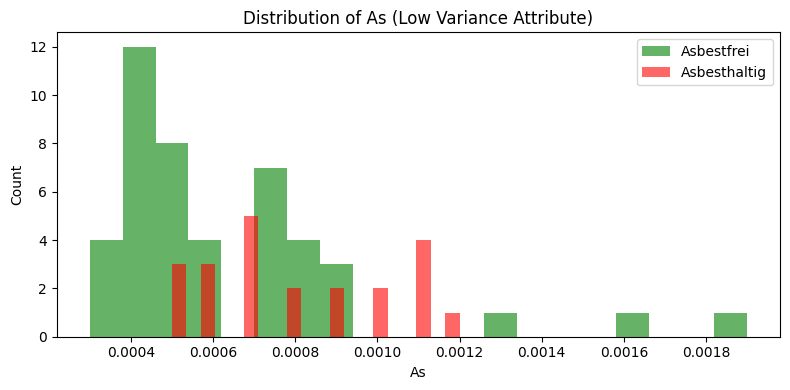

Y: 0.000001


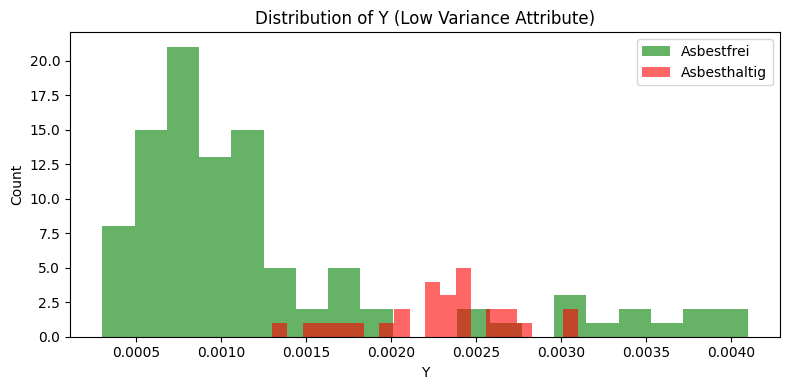


Shape after removing low variance attributes: (128, 21)
Remaining columns: [' ID', 'Asbest', 'Pb', 'Rb', 'Cu', 'Cr', 'Zr', 'Ni', 'Ba', 'Sr', 'Zn', 'Mn', 'P', 'Ti', 'S', 'K2O', 'Fe', 'MgO', 'Al2O3', 'Ca', 'SiO2']


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

'''
This cell is the implementation of the data preprocessing pipeline, as described in section 2 of the project report.
The processing is done step-by-step, and the data is saved in the /data directory.
'''

# random seed for the procedure
seed = 1

# Function to ensure that the decimal separation is consistent when loading the .csv data
def convert_numeric(x):
    if pd.isna(x) or x == 'NA':
        return np.nan
    if isinstance(x, str):
        return float(str(x).replace(',','.'))
    return x

# Load the first data from .csv -> only asbestos free samples 
steffenFrei = pd.read_csv(
    "data/SteffenAsbestfrei.csv",
    sep=",",
    decimal=".",
    na_values=["NA"],
    converters={col: convert_numeric 
               for col in pd.read_csv("data/SteffenAsbestfrei.csv", sep=",", nrows=0).columns},
)

# Load the asbestos samples (including some more asbestos free datapoints) 
steffenTest = pd.read_csv(
    "data/testdaten.csv",
    sep=",",
    decimal=".",
    na_values=["NA"],
    converters={col: convert_numeric 
               for col in pd.read_csv("data/SteffenAsbestfrei.csv", sep=",", nrows=0).columns},
)

# Convert the asbestos and id columns to be integers 
columns_to_convert = ['Asbest', ' ID']
for col in columns_to_convert:
    steffenFrei[col] = steffenFrei[col].astype('int64')
    steffenTest[col] = steffenTest[col].astype('int64')

# Attritbute Columns
SteffenFreiSpalten = set(steffenFrei.columns[0:])
SteffenTestSpalten = set(steffenTest.columns[0:])

# Only keep attributes that appear in both datasets
gemeinsameAttribute = SteffenFreiSpalten
spaltenGefiltert = list(gemeinsameAttribute)
steffenFreiGefiltert = steffenFrei[spaltenGefiltert].copy()
steffenTestGefiltert = steffenTest[spaltenGefiltert].copy()

# Join
kombinierteDaten = pd.concat([
    steffenFreiGefiltert, 
    steffenTestGefiltert
], ignore_index=True)

# Step 1: Perform a train/test split

# Shuffle the data for reproducibility -> Seed 4 is the worst case we saw during experiments 
kombinierteDaten_shuffled = kombinierteDaten.sample(frac=1, random_state=seed).reset_index(drop=True)

# Extraction of the test set
asbesthaltig_idx = kombinierteDaten_shuffled[kombinierteDaten_shuffled['Asbest'] == 1].index[:6]
asbestfrei_idx = kombinierteDaten_shuffled[kombinierteDaten_shuffled['Asbest'] == 0].index[:25]
test_indices = asbesthaltig_idx.tolist() + asbestfrei_idx.tolist()
test_set = kombinierteDaten_shuffled.loc[test_indices].reset_index(drop=True)

# Remove test set from training data
kombinierteDaten = kombinierteDaten_shuffled.drop(test_indices).reset_index(drop=True)


# Step 2: Remove Attributes with too many NaN Values

# Percentage of NaN 
nan_percentages = kombinierteDaten.isna().mean() * 100

# Only keep columns with less than 50% NaN
columns_to_keep = nan_percentages[nan_percentages < 50].index
kombinierteDaten_filtered = kombinierteDaten[columns_to_keep]

# Reorder columns to have ID first and Asbest second
desired_order = [' ID', 'Asbest'] + [col for col in kombinierteDaten_filtered.columns if col not in [' ID', 'Asbest']]
kombinierteDaten_filtered = kombinierteDaten_filtered[desired_order]

# Information on the removed columns
removed_columns = set(kombinierteDaten.columns) - set(columns_to_keep)
print(f"Remove {len(removed_columns)} attributes with ≥50% NaN values:")
print("")
for col in removed_columns:
    print(f"{col}: {nan_percentages[col]:.1f}% NaN")
    # Find rows where this column is NOT NaN
    not_nan_mask = ~kombinierteDaten[col].isna()
    if not_nan_mask.sum() > 0:
        class_counts = kombinierteDaten.loc[not_nan_mask, 'Asbest'].value_counts()
        print(f"  -> Asbestos-free: {class_counts.get(0, 0)}")
        print(f"  -> Asbestos: {class_counts.get(1, 0)}")
        print("")
    else:
        print("  -> No non-NaN datapoints for this attribute.")
        print("")

# Step 3: Identify and plot low variance attributes

# Calculate variance for numeric columns starting from the 3rd column
numeric_columns = kombinierteDaten_filtered.select_dtypes(include=[np.number]).columns[2:]
variances = kombinierteDaten_filtered[numeric_columns].var()

# Sort variances in ascending order
sorted_variances = variances.sort_values()

# Set threshold and identify low variance attributes
threshold = sorted_variances.median() * 0.01
low_variance_attrs = sorted_variances[sorted_variances < threshold]

# Plot distribution of attributes marked for removal
print(f"\nRemoving attributes with variance < {threshold:.6f}:")
for attr, var in low_variance_attrs.items():
    print(f"{attr}: {var:.6f}")
    # Distribution plot for each low variance attribute
    plt.figure(figsize=(8, 4))
    asbestfrei = kombinierteDaten_filtered[kombinierteDaten_filtered['Asbest'] == 0][attr]
    asbesthaltig = kombinierteDaten_filtered[kombinierteDaten_filtered['Asbest'] == 1][attr]
    plt.hist(asbestfrei, bins=20, color='green', alpha=0.6, label='Asbestfrei')
    plt.hist(asbesthaltig, bins=20, color='red', alpha=0.6, label='Asbesthaltig')
    plt.title(f"Distribution of {attr} (Low Variance Attribute)")
    plt.xlabel(attr)
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Remove low variance attributes from the dataset -> If the plots suggest otherwise, revert this
high_variance_columns = [' ID', 'Asbest'] + list(sorted_variances[sorted_variances >= threshold].index)
kombinierteDaten_filtered = kombinierteDaten_filtered[high_variance_columns]

# Fill the NaN values with 0 -> important for regression analysis
kombinierteDaten_filtered = kombinierteDaten_filtered.fillna(0)

# Save the updated filtered dataset
kombinierteDaten_filtered.to_csv(
    "data/kombinierteDaten_filtered_highvar.csv",
    sep=";",
    decimal=".",
    index=False
)

print(f"\nShape after removing low variance attributes: {kombinierteDaten_filtered.shape}")
print("Remaining columns:", kombinierteDaten_filtered.columns.tolist())

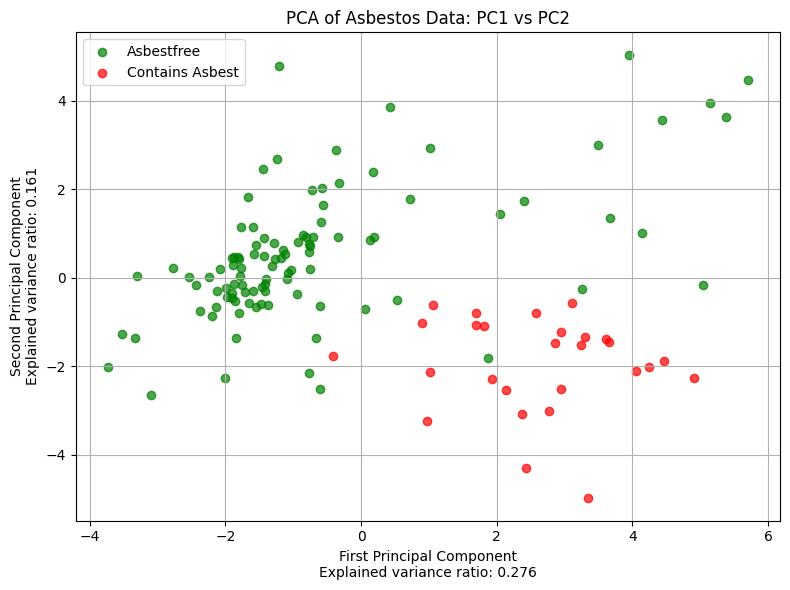

Proportion of Variance Explained (PVE) for the first 10 PCs:
PC1: 0.2760
PC2: 0.1613
PC3: 0.1053
PC4: 0.0696
PC5: 0.0669
PC6: 0.0550
PC7: 0.0475
PC8: 0.0427
PC9: 0.0328
PC10: 0.0281


In [2]:
from sklearn.decomposition import PCA
import os 

"""
This cell implements the PCA, as described in Section 3.1 of the report. The pairwise plots are saved in the /plots/pairwise_pcs directory. 
The console outputs are the PVE of the first 10 components, as well as the plot of PC1 against PC2.
"""

# PCA for the asbestos data
features = [col for col in kombinierteDaten_filtered.columns if col not in [' ID', 'Asbest']]
X = kombinierteDaten_filtered[features]
y = kombinierteDaten_filtered['Asbest']

# Normalize
scaler_all = StandardScaler()
X_scaled_all = scaler_all.fit_transform(X)
pca_all = PCA()
X_pca_all = pca_all.fit_transform(X_scaled_all)

# Create visualization of first two components
plt.figure(figsize=(8, 6))
mask_free = y == 0
mask_containing = y == 1

plt.scatter(X_pca_all[mask_free, 0], X_pca_all[mask_free, 1], 
           c='green', label='Asbestfree', alpha=0.7)
plt.scatter(X_pca_all[mask_containing, 0], X_pca_all[mask_containing, 1], 
           c='red', label='Contains Asbest', alpha=0.7)

plt.xlabel(f'First Principal Component\nExplained variance ratio: {pca_all.explained_variance_ratio_[0]:.3f}')
plt.ylabel(f'Second Principal Component\nExplained variance ratio: {pca_all.explained_variance_ratio_[1]:.3f}')
plt.title('PCA of Asbestos Data: PC1 vs PC2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print the explained variance ratio for the first 10 PCs
print("Proportion of Variance Explained (PVE) for the first 10 PCs:")
for i, pve in enumerate(pca_all.explained_variance_ratio_[:10], 1):
    print(f"PC{i}: {pve:.4f}")

# Create output directory if it doesn't exist
output_dir = "plots/pairwise_pcs"
os.makedirs(output_dir, exist_ok=True)

# Pairwise plots for all combinations of the first 10 PCs
n_pcs = 10
pcs = pca_all.transform(X_scaled_all)[:, :n_pcs]
y_arr = np.array(kombinierteDaten_filtered['Asbest'])

for i in range(n_pcs):
    for j in range(i+1, n_pcs):
        plt.figure(figsize=(8, 6))
        plt.scatter(
            pcs[y_arr == 0, i], pcs[y_arr == 0, j],
            c='green', label='Asbestfrei', alpha=0.6
        )
        plt.scatter(
            pcs[y_arr == 1, i], pcs[y_arr == 1, j],
            c='red', label='Asbesthaltig', alpha=0.6
        )
        plt.xlabel(f'PC{i+1}')
        plt.ylabel(f'PC{j+1}')
        plt.title(f'Pairwise Plot: PC{i+1} vs PC{j+1}')
        plt.legend()
        plt.tight_layout()
        plt.grid(True)
        plt.savefig(f"{output_dir}/PC{i+1}_vs_PC{j+1}.png")
        plt.close()


=== Balanced Classifier ===
Cross-validation accuracy: 0.945 (+/- 0.039)


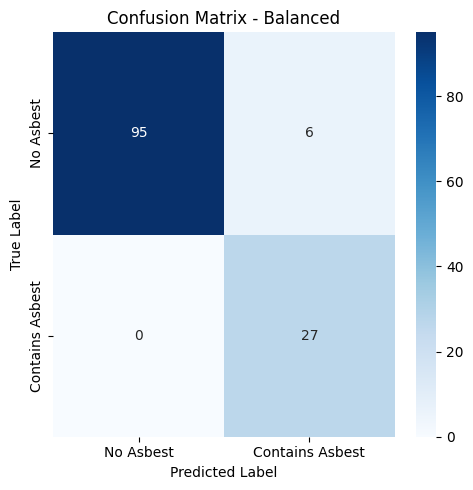


=== Custom Weighted Classifier ===
Cross-validation accuracy: 0.937 (+/- 0.108)


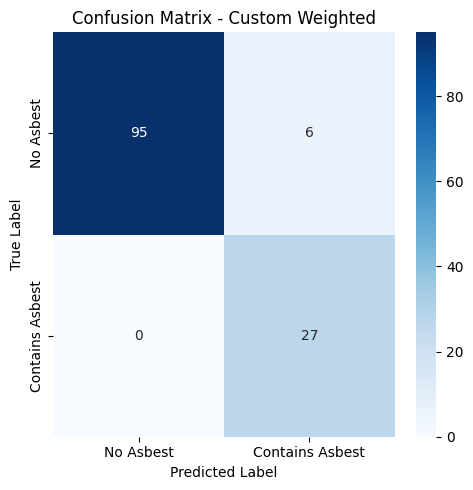

Logistic Regression Coefficients and 95% Confidence Intervals (PC1, PC2, PC3):

           coef  lower 95%  upper 95%
const -4.132698  -6.243315  -2.022082
PC1    1.310720   0.598914   2.022526
PC2   -2.303391  -3.612202  -0.994580
PC3   -0.593922  -1.524693   0.336849


In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import statsmodels.api as sm
import pandas as pd

'''
In this cell, the two different logistic regression models from the section 3.2 of the report are implemented and analyzed via cross-validation.
The accuracy is also given, other evaluation metrics are not printed due to the small number of test samples to improve readability of the notebook :)
'''

# Use first 3 PCs as features for all data
X_pca_3 = X_pca_all[:, :3]

# Option 1: Automatic balanced weights
clf = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')

# Option 2: Custom weights (putting even more emphasis on positive class)
custom_weights = {0: 1, 1: 5}  # 5 times more weight on asbestos class
clf_custom = LogisticRegression(random_state=42, max_iter=1000, class_weight=custom_weights)

# Train both classifiers and compare results
classifiers = {
    'Balanced': clf,
    'Custom Weighted': clf_custom
}

for name, classifier in classifiers.items():
    print(f"\n=== {name} Classifier ===")
    
    # Perform 5-fold cross-validation
    cv_scores = cross_val_score(classifier, X_pca_3, y, cv=5)
    print(f"Cross-validation accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    
    # Fit and predict
    classifier.fit(X_pca_3, y)
    y_pred = classifier.predict(X_pca_3)
    
    # Plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(5, 5))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Asbest', 'Contains Asbest'],
                yticklabels=['No Asbest', 'Contains Asbest'])
    
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()


# Confidence intervals for the coefficients of the PC-based logistic regression
X_sm = pd.DataFrame(X_pca_3, columns=['PC1', 'PC2', 'PC3'])
X_sm = sm.add_constant(X_sm)
y_sm = y

# Fit logistic regression with statsmodels
model = sm.Logit(y_sm, X_sm)
result = model.fit(disp=0)

# Print coefficients and 95% confidence intervals
print("Logistic Regression Coefficients and 95% Confidence Intervals (PC1, PC2, PC3):\n")
summary_df = pd.DataFrame({
    "coef": result.params,
    "lower 95%": result.conf_int()[0],
    "upper 95%": result.conf_int()[1]
})
print(summary_df)

/Users/aaronzumdick/VSCode/asbest/venv/lib/python3.13/site-packages/scs/__init__.py:83: UserWarning: Converting A to a CSC (compressed sparse column) matrix; may take a while.
  warn(


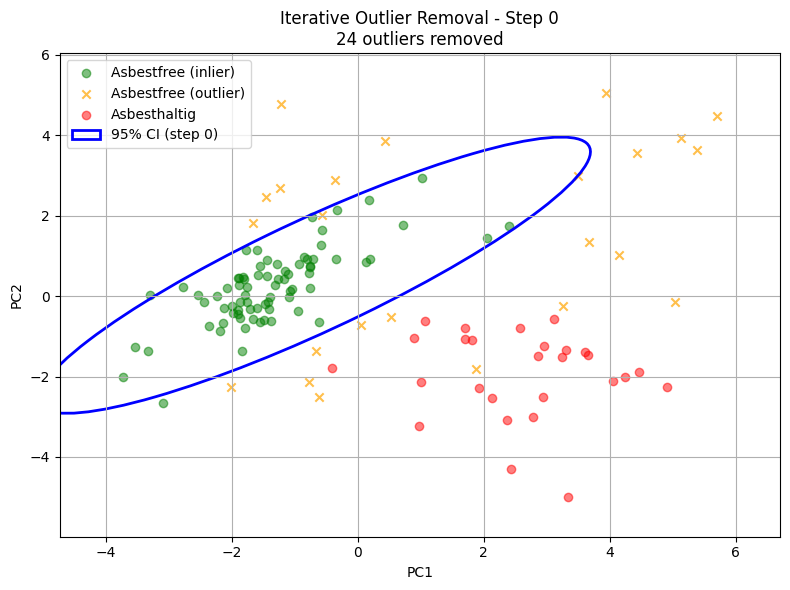

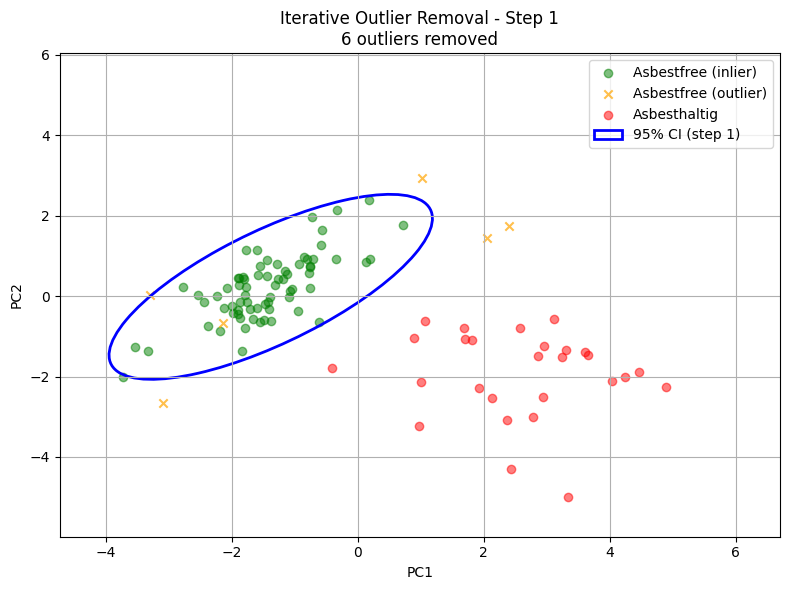

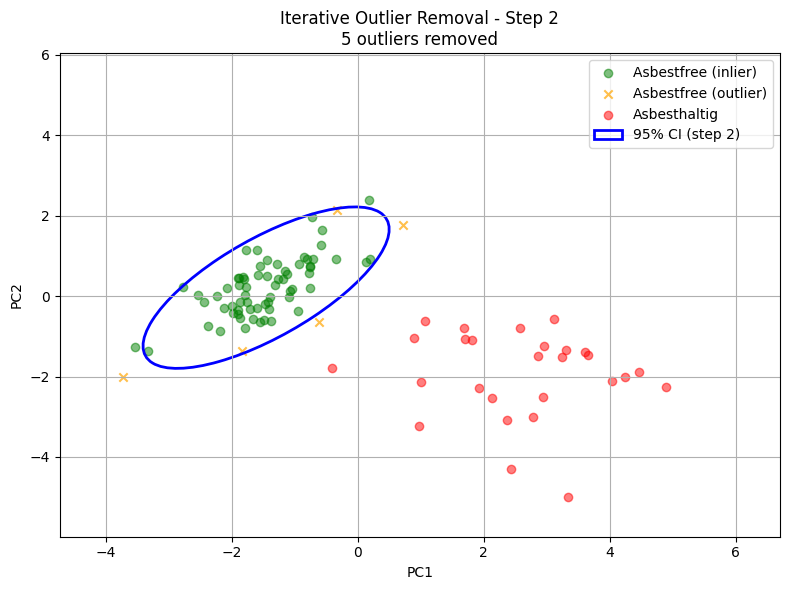

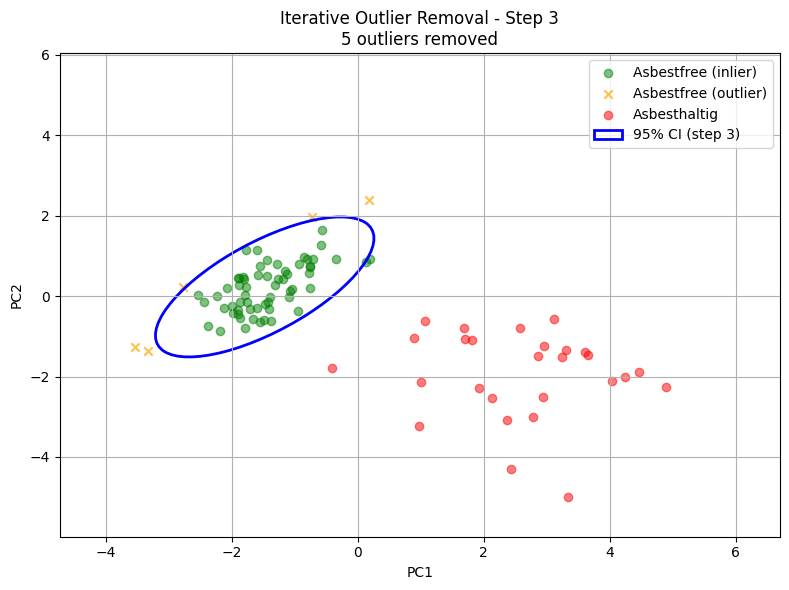

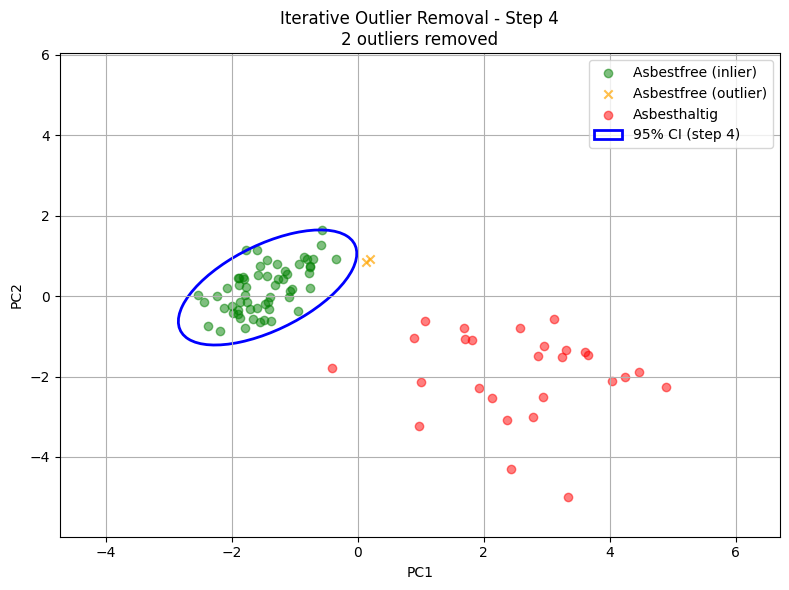

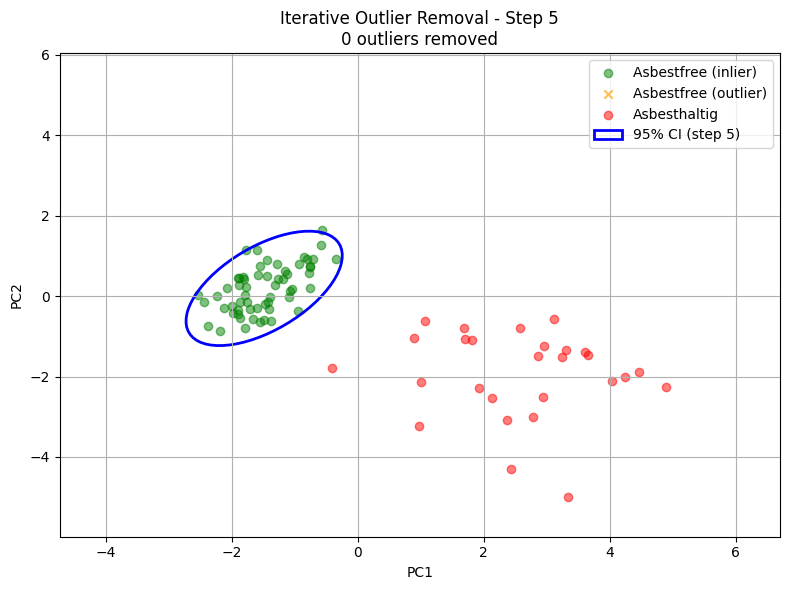

In [4]:
import cvxpy as cp
from scipy.stats import chi2
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

''' 
In this cell we implement the iterative approach to compute the confidence ellipse to classify points as almost surely asbestos free.
'''
q_value = 0.95 # Here you can define the q-value for the whole process. 
p_value = 0.001

def constrainedGaussian(A, B, p):
    """
    This function estimates the parameters of a gaussian distribution using constrained maximum likelihood -> The p-value defines the maximum probability
    that is allowed for a point from dataset B (or a point even further away) to be generated by the gaussian. Note: The mean is calculated as the mean of all
    datapoints from the set A, thus only the variance is 'optimized'
    
    A = ndarray of datapoints of class A
    B = ndarray of datapoints of class B
    p = desired p-value
    Return: mean, variance estimate of the gaussian
    """

    A = np.asarray(A)
    B = np.asarray(B)
    n, d = A.shape
    m, f = B.shape


    if (d != f):
        raise ValueError("The dimensions of the input data are not equal!")
    
    # Transform the p-value into Mahanalobis Distance -> Tau is the minimal Mahanalobis-Distance a point of the set B is allowed to have from the estimated Gaussian
    tau = chi2.ppf(1 - p, df=d)

    # Optimization: Find the Gaussian that best desribes the data under the constraint
    my = np.mean(A, axis=0)

    sigma = cp.Variable((d, d), PSD = True) # -> Variance Matrix (bzw. das inverse davon oder so)
    
    log_likelihood = cp.sum([cp.quad_form(x - my, sigma) for x in A])
    log_likelihood = 0.5 * log_likelihood - 0.5 * n * cp.log_det(sigma)

    constraints = []
    for x in B:
        diff = (x - my)
        diff_col = cp.reshape(diff, (d, 1), 'F')
        diff_row = cp.reshape(diff, (1, d), 'F')
        constraints.append(cp.trace(sigma @ (diff_col @ diff_row)) >= tau)

    problem = cp.Problem(cp.Minimize(log_likelihood), constraints)
    problem.solve()

    if problem.status not in ["optimal", "optimal_inaccurate"]:
        raise ValueError(f"Optimization failed: {problem.status}")

    my_hat = my
    Lambda_hat = sigma.value
    Sigma_hat = np.linalg.inv(Lambda_hat)

    return my_hat, Sigma_hat

# Function to compute the mahalanobis distance from a point x to a gaussian distribution with mean and covariance matrix
def mahalanobis_distance(x, mean, cov):
    diff = x - mean
    return np.sqrt(diff.T @ np.linalg.inv(cov) @ diff)


# Function to plot the covariance ellipse -> q = confidence level
def plot_cov_ellipse(mean, cov, ax, color, label, q):
    vals, vecs = np.linalg.eigh(cov[:2, :2])
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    width, height = 2 * np.sqrt(vals * chi2.ppf(q, 2))
    ellip = Ellipse(xy=mean[:2], width=width, height=height, angle=theta,
                    edgecolor=color, fc='None', lw=2, label=label)
    ax.add_patch(ellip)

# Prepare the data for the algorithm -> Seperate PCs
X_pc = X_pca_all[:, :3]
y_arr = np.array(y)

# Separate the data by class
X_pc_free = X_pc[y_arr == 0]
X_pc_asbest = X_pc[y_arr == 1]

# Iterative outlier removal and plotting: In each step, the asbestos-free datapoints who lie outside of the 95% Confidence Ellipse of the Gaussian
# get removed from the training set, and the mean and constrained gaussian are re-calculated, until no asbestos-free point lies outside of the Confidence Ellipsoid!

# Ensure that the plots are on the same scale, so the evolution of the ellips is visualised well.
all_x = X_pc_free[:, 0]
all_y = X_pc_free[:, 1]
all_x_asbest = X_pc_asbest[:, 0]
all_y_asbest = X_pc_asbest[:, 1]

x_min = min(all_x.min(), all_x_asbest.min()) - 1
x_max = max(all_x.max(), all_x_asbest.max()) + 1
y_min = min(all_y.min(), all_y_asbest.min()) - 1
y_max = max(all_y.max(), all_y_asbest.max()) + 1

# Iterative outlier removal and plotting
X_A = X_pc_free.copy()
X_B = X_pc_asbest.copy()
step = 0
while True:
    # Fit constrained Gaussian
    mean, var = constrainedGaussian(X_A, X_B, p_value)  # -> p-value

    # Calculate Mahalanobis distances for all asbest-free points
    dists = np.array([mahalanobis_distance(x, mean, var) for x in X_A])
    threshold = np.sqrt(chi2.ppf(q_value, df=3))  # 3 PCs

    # Find inliers 
    inlier_mask = dists <= threshold
    num_outliers = np.sum(~inlier_mask)

    # Plot current step
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(X_A[inlier_mask, 0], X_A[inlier_mask, 1], c='green', label='Asbestfree (inlier)', alpha=0.5)
    ax.scatter(X_A[~inlier_mask, 0], X_A[~inlier_mask, 1], c='orange', label='Asbestfree (outlier)', alpha=0.7, marker='x')
    ax.scatter(X_B[:, 0], X_B[:, 1], c='red', label='Asbesthaltig', alpha=0.5)
    plot_cov_ellipse(mean, var, ax, 'blue', f'95% CI (step {step})', q_value)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_title(f'Iterative Outlier Removal - Step {step}\n{num_outliers} outliers removed')
    ax.legend()
    plt.grid(True)
    plt.tight_layout()
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    plt.show()

    # Stop if no more outliers
    if num_outliers == 0:
        break

    # Remove outliers for next iteration
    X_A = X_A[inlier_mask]
    step += 1


=== Balanced Classifier on Held-out Test Set ===
Test set accuracy: 1.000


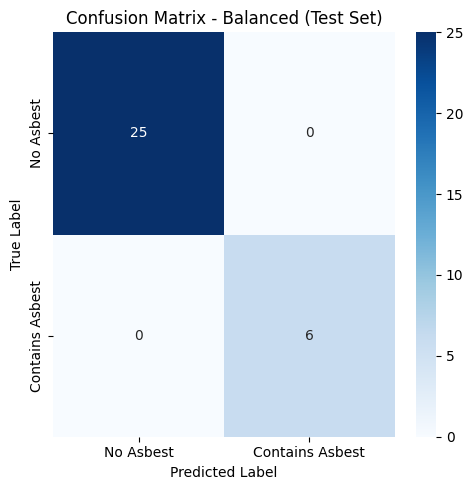


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00         6

    accuracy                           1.00        31
   macro avg       1.00      1.00      1.00        31
weighted avg       1.00      1.00      1.00        31


=== Custom Weighted Classifier on Held-out Test Set ===
Test set accuracy: 1.000


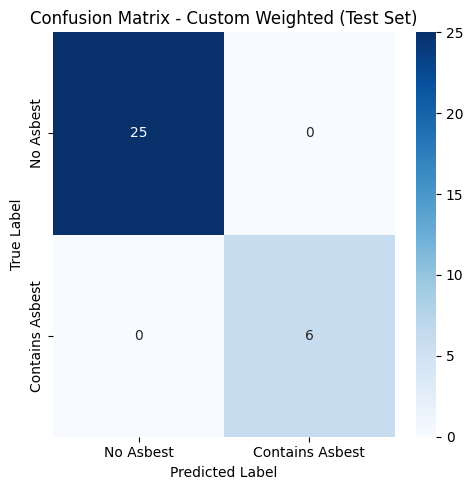


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00         6

    accuracy                           1.00        31
   macro avg       1.00      1.00      1.00        31
weighted avg       1.00      1.00      1.00        31



In [5]:
# Evaluate Logistic Regression Classifiers on the held out test set

# 1. Prepare test features (same columns/order as training)
test_features = [col for col in kombinierteDaten_filtered.columns if col not in [' ID', 'Asbest']]
X_test = test_set[test_features].fillna(0)

# 2. Scale and PCA-transform using training scaler and PCA
X_test_scaled = scaler_all.transform(X_test)
X_test_pca = pca_all.transform(X_test_scaled)
X_test_pca_3 = X_test_pca[:, :3]

# 3. True labels
y_test = test_set['Asbest']

# 4. Evaluate both classifiers
for name, classifier in classifiers.items():
    print(f"\n=== {name} Classifier on Held-out Test Set ===")
    y_proba = classifier.predict_proba(X_test_pca_3)[:, 1]
    # Use threshold 0.5 (standard) or adjust as needed
    y_pred = (y_proba >= 0.5).astype(int)
    accuracy = (y_pred == y_test).mean()
    print(f"Test set accuracy: {accuracy:.3f}")
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Asbest', 'Contains Asbest'],
                yticklabels=['No Asbest', 'Contains Asbest'])
    plt.title(f'Confusion Matrix - {name} (Test Set)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

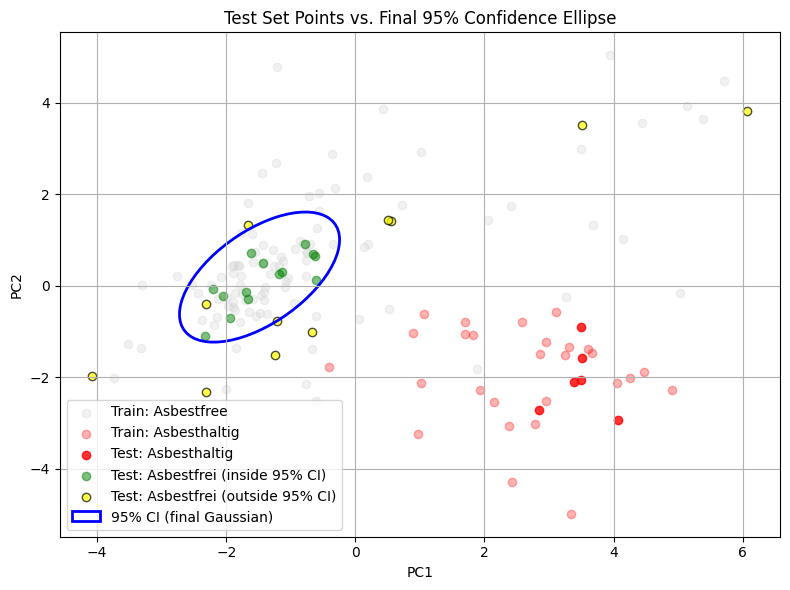

Classification report for test set:
  Red (asbesthaltig): 6
  Green (asbestfrei inside 95% CI): 14
  Yellow (asbestfrei outside 95% CI): 11
  Surely Asbestfrei: 56.0 %


In [6]:
# Evaluate the Confidence Ellipse Classification on the held out test set

# Prepare test set in PC space (first 3 PCs)
X_test = test_set[[col for col in kombinierteDaten_filtered.columns if col not in [' ID', 'Asbest']]].fillna(0)
X_test_scaled = scaler_all.transform(X_test)
X_test_pca = pca_all.transform(X_test_scaled)
X_test_pca_3 = X_test_pca[:, :3]
y_test = np.array(test_set['Asbest'])

# Calculate Mahalanobis distances for test set
dists = np.array([mahalanobis_distance(x, mean, var) for x in X_test_pca_3])
threshold = np.sqrt(chi2.ppf(q_value, df=3))

inside_mask = (dists <= threshold)
outside_mask = ~inside_mask
asbest_mask = (y_test == 1)
asbestfree_mask = (y_test == 0)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot training data for context
ax.scatter(X_pc_free[:, 0], X_pc_free[:, 1], c='lightgrey', label='Train: Asbestfree', alpha=0.3)
ax.scatter(X_pc_asbest[:, 0], X_pc_asbest[:, 1], c='red', label='Train: Asbesthaltig', alpha=0.3)

# Plot test points: asbesthaltig (red), asbestfrei inside (green), asbestfrei outside (yellow)
ax.scatter(X_test_pca_3[asbest_mask, 0], X_test_pca_3[asbest_mask, 1], c='red',alpha=0.8, label='Test: Asbesthaltig')
ax.scatter(X_test_pca_3[asbestfree_mask & inside_mask, 0], X_test_pca_3[asbestfree_mask & inside_mask, 1], c='green', alpha=0.5, label='Test: Asbestfrei (inside 95% CI)')
ax.scatter(X_test_pca_3[asbestfree_mask & outside_mask, 0], X_test_pca_3[asbestfree_mask & outside_mask, 1], c='yellow',alpha=0.7,label='Test: Asbestfrei (outside 95% CI)', edgecolors='black')

# Plot the final 99% confidence Ellipse
plot_cov_ellipse(mean, var, ax, 'blue', '95% CI (final Gaussian)', q_value)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Test Set Points vs. Final 95% Confidence Ellipse')
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Classification report
n_red = np.sum(asbest_mask)
n_green = np.sum(asbestfree_mask & inside_mask)
n_yellow = np.sum(asbestfree_mask & outside_mask)
print("Classification report for test set:")
print(f"  Red (asbesthaltig): {n_red}")
print(f"  Green (asbestfrei inside 95% CI): {n_green}")
print(f"  Yellow (asbestfrei outside 95% CI): {n_yellow}")
print(f"  Surely Asbestfrei: {100*n_green/(n_green+n_yellow)} %")

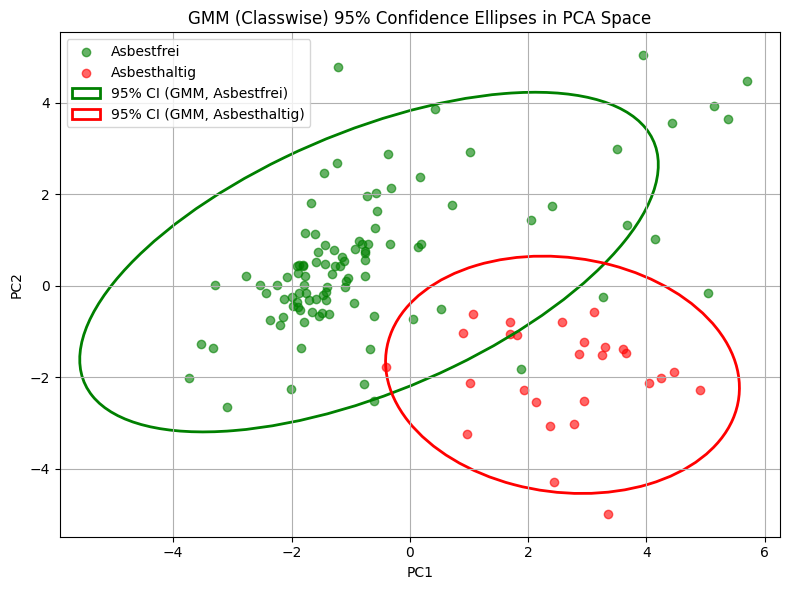

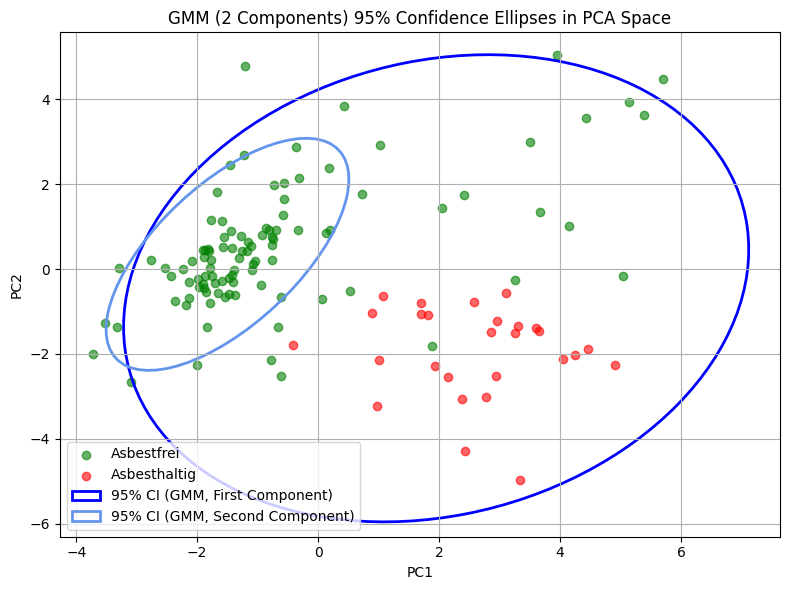

In [7]:
# Calculate Gaussian Mixture Models with one and two components to compare to the iterative algorithm 

from sklearn.mixture import GaussianMixture

# Fit a Gaussian Mixture Model with one component on the first 3 PCs, only using asbestos-free points
X_pc_free = X_pc[y_arr == 0]
X_pc_asbest = X_pc[y_arr == 1]
X_pc_both = X_pca_all[:, :3]

gmm_free = GaussianMixture(n_components=1, covariance_type='full', random_state=1)
gmm_asbest = GaussianMixture(n_components=1, covariance_type='full', random_state=1)
gmm_all = GaussianMixture(n_components=2, covariance_type='full', random_state=1)

gmm_free.fit(X_pc_free)
gmm_asbest.fit(X_pc_asbest)
gmm_all.fit(X_pc_both)

plt.figure(figsize=(8, 6))
plt.scatter(X_pc[y_arr == 0, 0], X_pc[y_arr == 0, 1], c='green', label='Asbestfrei', alpha=0.6)
plt.scatter(X_pc[y_arr == 1, 0], X_pc[y_arr == 1, 1], c='red', label='Asbesthaltig', alpha=0.6)

ax = plt.gca()
plot_cov_ellipse(gmm_free.means_[0], gmm_free.covariances_[0], ax, 'green', '95% CI (GMM, Asbestfrei)', q=0.95)
plot_cov_ellipse(gmm_asbest.means_[0], gmm_asbest.covariances_[0], ax, 'red', '95% CI (GMM, Asbesthaltig)', q=0.95)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('GMM (Classwise) 95% Confidence Ellipses in PCA Space')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(X_pc[y_arr == 0, 0], X_pc[y_arr == 0, 1], c='green', label='Asbestfrei', alpha=0.6)
plt.scatter(X_pc[y_arr == 1, 0], X_pc[y_arr == 1, 1], c='red', label='Asbesthaltig', alpha=0.6)
ax = plt.gca()
plot_cov_ellipse(gmm_all.means_[0], gmm_all.covariances_[0], ax, 'blue', '95% CI (GMM, First Component)', q=0.95)
plot_cov_ellipse(gmm_all.means_[1], gmm_all.covariances_[1], ax, 'cornflowerblue', '95% CI (GMM, Second Component)', q=0.95)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('GMM (2 Components) 95% Confidence Ellipses in PCA Space')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
